In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import seaborn as sns
from pathlib import Path
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
im0_dir = '/DATA/DATA/0'
im1_dir = '/DATA/DATA/1'

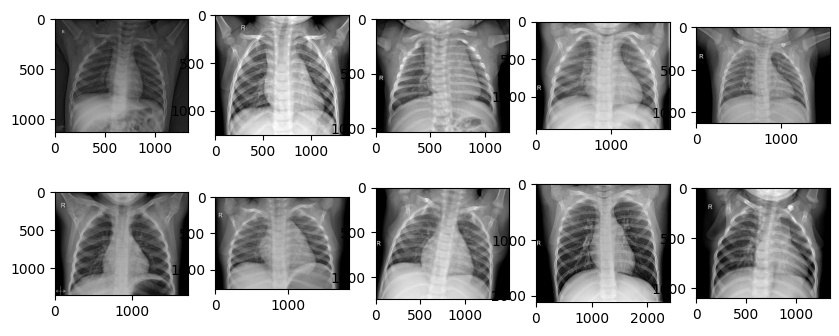

In [5]:
# Data visualisation
plt.figure(figsize=(10, 4), dpi=100)
i=0
for image in os.listdir(im0_dir):
    
    if i < 10:
        img = cv2.imread(im0_dir + '/' + image)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        i+=1
    else:
        break

In [6]:
image = os.listdir(im0_dir)[0]
img = cv2.imread(im0_dir + '/' + image)

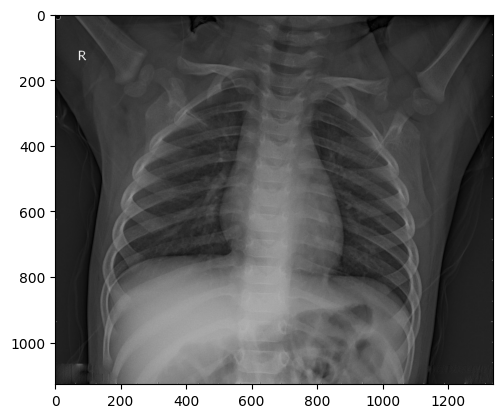

In [7]:
plt.imshow(img)

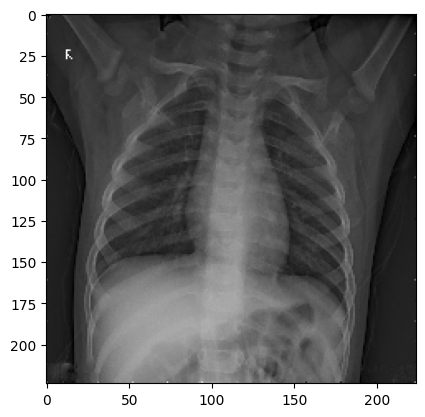

In [8]:
resized_img = cv2.resize(img, dsize=(224, 224))
plt.imshow(resized_img)

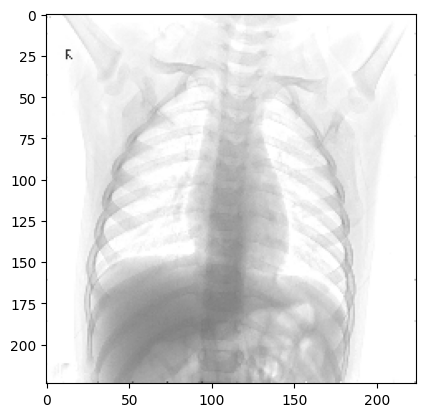

In [9]:
plt.imshow(cv2.convertScaleAbs(resized_img, alpha=-1, beta=300))

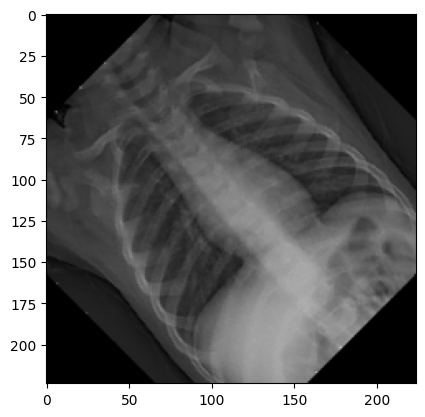

In [10]:
m = cv2.getRotationMatrix2D(center=(resized_img.shape[0]//2-1, resized_img.shape[1]//2-1), angle=45, scale=1)
img_rot = cv2.warpAffine(resized_img, m, dsize=(224, 224))
plt.imshow(img_rot)

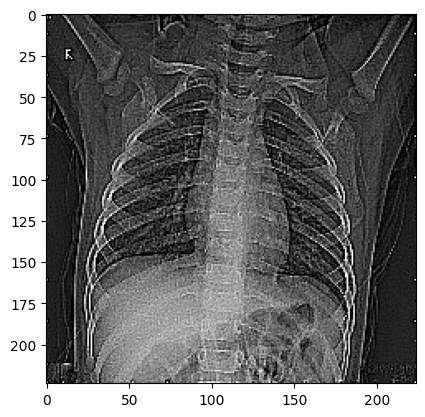

In [11]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(resized_img, -1, kernel)
plt.imshow(im)

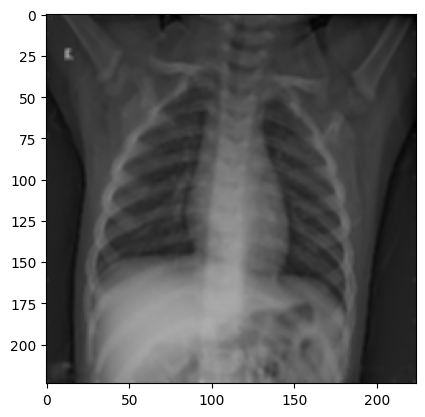

In [12]:
plt.imshow(cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=2))

In [13]:
im0 = []
im1 = []

# Filling up the lists with augmented data for better performance

for image in os.listdir(im0_dir):
    
    img = cv2.imread(im0_dir + '/' + image)
    
    resized_img = cv2.resize(img, dsize=(227, 227))
    im0.append(resized_img)
    
    im_trans = cv2.convertScaleAbs(resized_img, alpha=-1, beta=300)
    im0.append(im_trans)
    
    m = cv2.getRotationMatrix2D(center=(resized_img.shape[0]//2-1, resized_img.shape[1]//2-1), angle=45, scale=1)
    img_rot = cv2.warpAffine(resized_img, m, dsize=(227, 227))
    im0.append(img_rot)
    
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(resized_img, -1, kernel)
    im0.append(im)
    
    blurr_im = cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=2)
    im0.append(blurr_im)
    
    trans_im = cv2.convertScaleAbs(resized_img, alpha=-1, beta=300)
    im0.append(trans_im)
    

for image in os.listdir(im1_dir):
    
    img = cv2.imread(im1_dir + '/' + image)
    
    resized_img = cv2.resize(img, dsize=(227, 227))
    im1.append(resized_img)
    
    im_trans = cv2.convertScaleAbs(resized_img, alpha=-1, beta=300)
    im1.append(im_trans)
    
    m = cv2.getRotationMatrix2D(center=(resized_img.shape[0]//2-1, resized_img.shape[1]//2-1), angle=45, scale=1)
    img_rot = cv2.warpAffine(resized_img, m, dsize=(227, 227))
    im1.append(img_rot)
    
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(resized_img, -1, kernel)
    im1.append(im)
    
    blurr_im = cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=2)
    im1.append(blurr_im)
    
    trans_im = cv2.convertScaleAbs(resized_img, alpha=-1, beta=300)
    im1.append(trans_im)

In [14]:
len(im0)

7806

In [15]:
len(im1)

10740

In [16]:
true_val = torch.ones(len(im0), dtype=torch.uint8)
false_val = torch.zeros(len(im1), dtype=torch.uint8)

In [17]:
labels = torch.cat((false_val, true_val))

In [18]:
labels

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.uint8)

In [19]:
torch.tensor(im0[0]).shape

torch.Size([227, 227, 3])

In [20]:
im = im0+im1
im_tensor_list = []
im_tensor_list = [torch.from_numpy(np.array(image)) for image in im]

image_tensor = torch.stack(im_tensor_list)

In [21]:
image_tensor.shape

torch.Size([18546, 227, 227, 3])

In [22]:
image_tensor.dtype

torch.uint8

In [23]:
# Preparing the Dataloader using image_tensor and labels
dataset = torch.utils.data.TensorDataset(image_tensor, labels)
                                    
# Preparing the train-test split by sampling from dataloader
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size = 32,
                                               shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size = 32,
                                               shuffle=True)

In [24]:
image, labels = next(iter(train_loader))
image.shape, labels.shape

(torch.Size([32, 227, 227, 3]), torch.Size([32]))

In [39]:
# Modelling AlexNet for classification using transfer learning 
model = torchvision.models.alexnet(pretrained=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [40]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [41]:
# Training the model on the dataset using pretrained weights
# Freezing the weights
for params in model.parameters():
    torch.requires_grad = True
    
# Adding a linear layer at the end of the classifier
num_classes = 2
linear_layer = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
model.classifier[-1] = linear_layer
model = model.to(device)

# Defining criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
n_epochs = 50

In [42]:
loss = []
training_acc = []
test_acc = []

# Training on our network
for epoch in range(n_epochs):
    
    train_correct = 0
    train_total = 0
    
    test_correct = 0
    test_total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device).float()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images.view(-1, 3, 227, 227))

        # Calculate and Backpropagate the loss
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()
        
        # Checking the training set accuracy
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = 100 * train_correct / train_total
    training_acc.append(train_accuracy)
    
    # Checking the accuracy on the test set
    
    for images, labels in test_loader:
        
        images = images.to(device).float()
        labels = labels.to(device)
        
        outputs = model(images.view(-1, 3, 227, 227))
        _, predicted = outputs.max(1)
        
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        
        
    test_accuracy = 100 * test_correct / test_total
    test_acc.append(test_accuracy)
    
    print(f"Epoch: {epoch+1}:\nTraining Accuracy: {train_accuracy: .2f}%\t Test Accuracy: {test_accuracy: .2f}%\n")


Epoch: 1:
Training Accuracy:  61.82%	 Test Accuracy:  67.21%

Epoch: 2:
Training Accuracy:  73.41%	 Test Accuracy:  74.66%

Epoch: 3:
Training Accuracy:  76.79%	 Test Accuracy:  79.00%

Epoch: 4:
Training Accuracy:  78.71%	 Test Accuracy:  80.29%

Epoch: 5:
Training Accuracy:  79.77%	 Test Accuracy:  80.56%

Epoch: 6:
Training Accuracy:  80.10%	 Test Accuracy:  80.83%

Epoch: 7:
Training Accuracy:  80.90%	 Test Accuracy:  80.83%

Epoch: 8:
Training Accuracy:  81.49%	 Test Accuracy:  82.83%

Epoch: 9:
Training Accuracy:  82.25%	 Test Accuracy:  75.03%

Epoch: 10:
Training Accuracy:  83.07%	 Test Accuracy:  82.37%

Epoch: 11:
Training Accuracy:  83.48%	 Test Accuracy:  81.69%

Epoch: 12:
Training Accuracy:  84.02%	 Test Accuracy:  82.88%

Epoch: 13:
Training Accuracy:  84.86%	 Test Accuracy:  83.93%

Epoch: 14:
Training Accuracy:  85.15%	 Test Accuracy:  81.45%

Epoch: 15:
Training Accuracy:  85.84%	 Test Accuracy:  84.17%

Epoch: 16:
Training Accuracy:  86.05%	 Test Accuracy:  83.93%

E

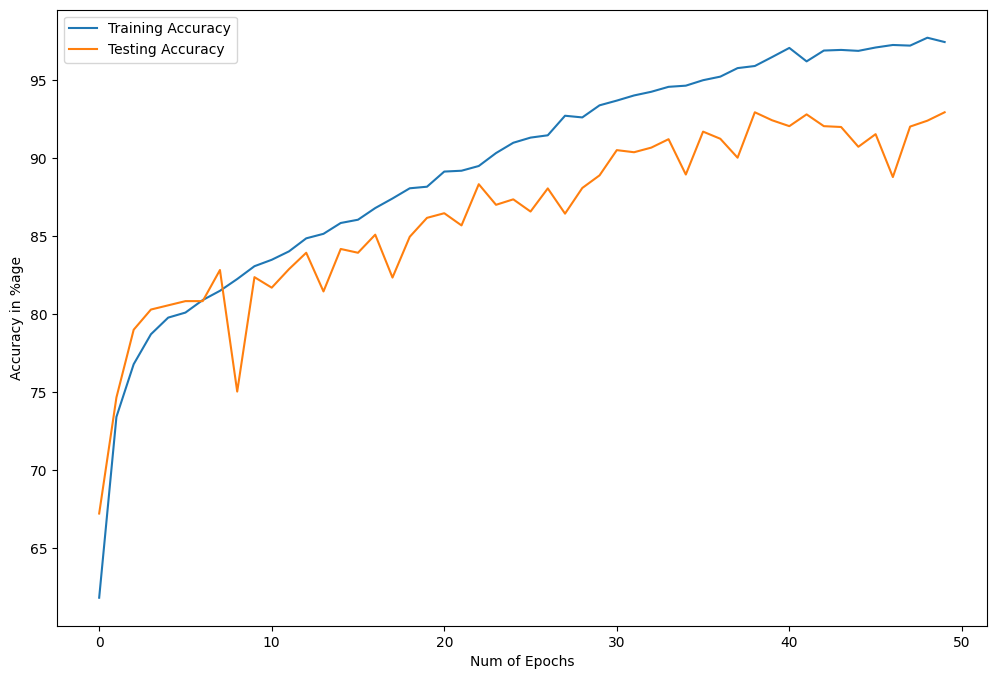

In [49]:
plt.figure(figsize=(12, 8), dpi=100)

plt.plot(np.arange(n_epochs), training_acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), test_acc, label = 'Testing Accuracy')

plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy in %age')
plt.legend()

In [45]:
for images, labels in test_loader:
        
        images = images.to(device).float()
        labels = labels.to(device)
        
        outputs = model(images.view(-1, 3, 227, 227))
        _, predicted = outputs.max(1)
        
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        
        
test_accuracy = 100 * test_correct / test_total
print(f'Final Accuracy on the test set is: {test_accuracy: .3f}%')

Final Accuracy on the test set is:  92.923%
